# Medical imaging

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Practicum 1: Computed Tomography Image Visualisation & Reconstruction
(Gabriel X, Iñigo Arriazu and Andrea Pérez)
Oct-Nov 2025
==============================================================================================

In this practicum, you will work with several topics covered in the theory sessions. In particular you will (1) simulate a simple and more complex phantoms, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over a single slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms. In addition, the Shepp–Logan phantom will be used to analyse noise during reconstruction.

### Aims:
- Generate simple and complex phantoms
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

``Remember to comment your code and provide some discussion on the results obtained for each section.``

In [7]:
%matplotlib inline
#!pip install scikit-image
!pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.6 MB/s eta 0:00:00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

### 2.1 Visualise a lung CT dicom image and create a phantom (2 points)

Open and visualise the Lung CT volume stored at the `LungCT-Diagnosis` folder. Read each of the indivdual `dcm` images, and display some 2D slices. Some basic image processing might be needed. Then, create a 3D phantom with the ribcages based on their HU and visualise the 3D rendering. Congratulations, you have created your first anthropomorphic phantom!

<img src='images_4_notebook/LungPhantomImage.png' width="400">


<img src='images_4_notebook/LungPhantomRendering.png' width="400">


Data was taken from https://www.cancerimagingarchive.net/collection/lungct-diagnosis/


In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
from pydicom.filereader import dcmread
from skimage.exposure import rescale_intensity
from skimage.morphology import ball, binary_opening, binary_closing, remove_small_objects
from skimage.measure import marching_cubes
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go

In [10]:
# ---------- 1) Read DICOM series ----------
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread

DATA_DIR = Path("LungCT-Diagnosis")  # adjust path as needed

def read_series(dicom_dir: Path):
    files = sorted([p for p in dicom_dir.rglob("*.dcm")])
    assert files, f"No DICOMs under {dicom_dir}"

    metas = []
    for f in files:
        ds = dcmread(str(f), stop_before_pixels=True, force=True)
        z = None
        if hasattr(ds, "ImagePositionPatient"):
            z = float(ds.ImagePositionPatient[2])
        inst = int(getattr(ds, "InstanceNumber", 0))
        metas.append((f, z, inst))

    # Sort slices
    if all(m[1] is not None for m in metas):
        metas.sort(key=lambda x: x[1])
    else:
        metas.sort(key=lambda x: x[2])

    # Read full pixel data
    slices = [dcmread(str(f[0]), force=True) for f in metas]
    image = np.stack([s.pixel_array for s in slices]).astype(np.int16)

    # Convert to Hounsfield Units (HU)
    for i, s in enumerate(slices):
        intercept = s.RescaleIntercept if 'RescaleIntercept' in s else 0
        slope = s.RescaleSlope if 'RescaleSlope' in s else 1
        image[i] = image[i] * slope + intercept

    return image, slices

# Read CT volume
ct_volume, ct_slices = read_series(DATA_DIR)
print("CT shape:", ct_volume.shape)

AssertionError: No DICOMs under LungCT-Diagnosis

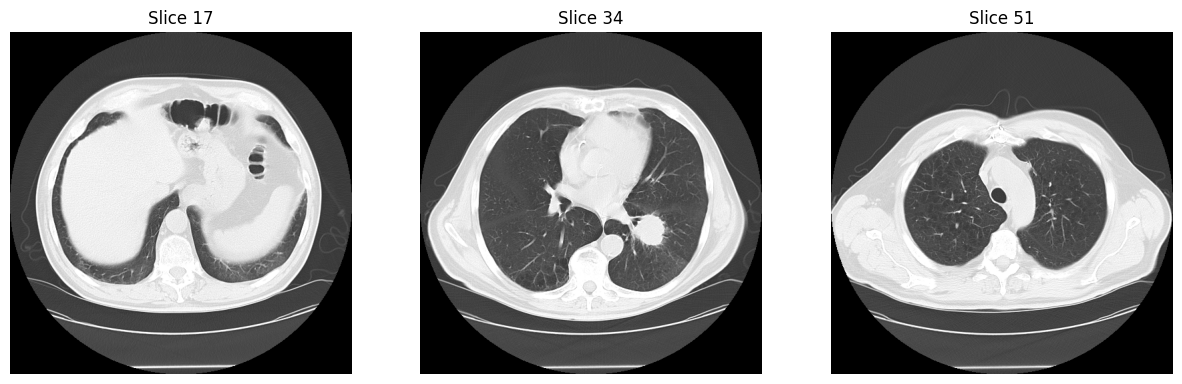

In [ ]:
# ---------- 2) 2D visualisation with window/level ----------

def show_slices(volume, slice_indices, window_center=0, window_width=1500):
    """
    Display selected slices with window/level adjustment.
    """
    min_val = window_center - window_width // 2
    max_val = window_center + window_width // 2

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(15, 5))
    if len(slice_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, slice_indices):
        img = np.clip(volume[idx], min_val, max_val)
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Slice {idx}")
        ax.axis("off")
    plt.show()

# Example: visualize middle slices in lung window
n_slices = ct_volume.shape[0]
show_slices(ct_volume, [n_slices//4, n_slices//2, 3*n_slices//4], window_center=-600, window_width=1500)


In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook"
# ---------- 3) Ribcage phantom via HU threshold ----------
from skimage import measure
import plotly.graph_objects as go

# Simple bone mask -> values above threshold are bone
BONE_TH =650
bone_mask = ct_volume >= BONE_TH

# Use marching cubes to extract surface mesh from 3D mask
verts, faces, normals, values = measure.marching_cubes(
    bone_mask.astype(np.uint8), level=0.5, step_size=2
)

print(f"Mesh vertices: {verts.shape[0]}, faces: {faces.shape[0]}")

# Create interactive 3D figure with Plotly
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=verts[:, 0],
            y=verts[:, 1],
            z=verts[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            color="lightgray",
            opacity=0.4,
        )
    ]
)

fig.update_layout(
    title="3D Ribcage Phantom (HU > 650)",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    width=800,
    height=800,
)

fig.show()


Mesh vertices: 37918, faces: 72498


In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------- 4) 3D rendering with marching cubes ----------
# Marching cubes expects (z, y, x) ordering, ensure correct shape
# and provide approximate voxel spacing if available
if hasattr(ct_slices[0], "PixelSpacing") and hasattr(ct_slices[0], "SliceThickness"):
    spacing = (
        float(ct_slices[0].SliceThickness),
        float(ct_slices[0].PixelSpacing[0]),
        float(ct_slices[0].PixelSpacing[1]),
    )
else:
    spacing = (1.0, 1.0, 1.0)  # default if metadata missing

print("Voxel spacing (z, y, x):", spacing)

# Extract surface mesh using marching cubes
verts, faces, normals, values = measure.marching_cubes(
    bone_mask.astype(np.uint8), level=0.5, spacing=spacing
)

# ---------- Visualization (Matplotlib 3D) ----------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create 3D polygon collection
mesh = Poly3DCollection(verts[faces], alpha=0.3)
mesh.set_facecolor('gray')
ax.add_collection3d(mesh)

# Set axes limits
ax.set_xlim(0, bone_mask.shape[2] * spacing[2])
ax.set_ylim(0, bone_mask.shape[1] * spacing[1])
ax.set_zlim(0, bone_mask.shape[0] * spacing[0])

ax.set_title("3D Ribcage Phantom (Marching Cubes)")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

plt.tight_layout()
plt.show()

Voxel spacing (z, y, x): (5.0, 0.830078, 0.830078)


In [ ]:
print("Tamaño del volumen:", bone_mask.shape)
print("Número de voxeles óseos:", np.sum(bone_mask))

Tamaño del volumen: (68, 512, 512)
Número de voxeles óseos: 72398


### 2.2 Create a simple and homogeneous phantom (1.5 points)

Create a more simple 2D phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/PhantomImage.png' width="400">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the synthetic lesion. Always remember to include the units of the axis when ploting a graph.

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

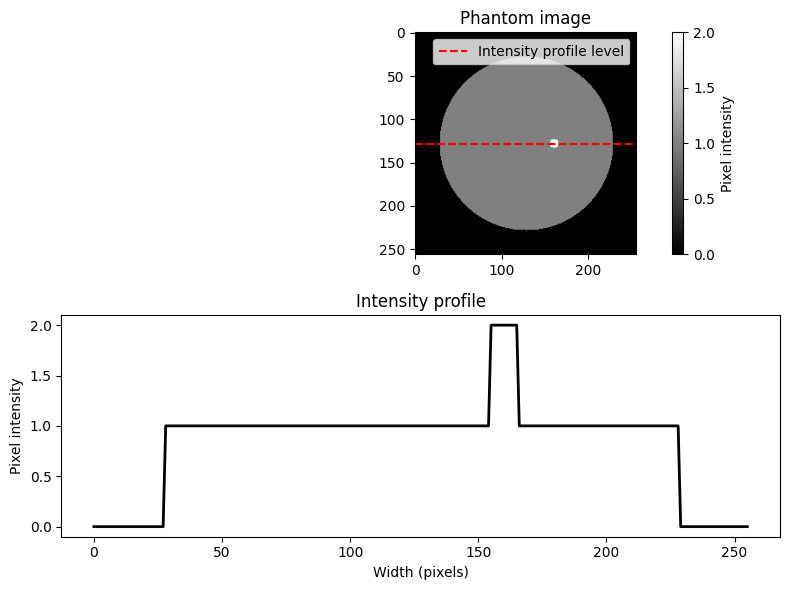

In [ ]:
# insert your code here
# ---------- Create 2D phantom ----------
h, w = 256, 256
phantom = np.zeros((h, w))  # background = 0

# Tissue 1: large circle
mask_tissue = create_circular_mask(h, w, center=(128, 128), radius=100)
phantom[mask_tissue] = 1  # pixel intensity = 1

# Tissue 2: small lesion
mask_lesion = create_circular_mask(h, w, center=(160, 128), radius=5)
phantom[mask_lesion] = 2  # pixel intensity = 2

# ---------- Plot phantom and intensity profile ----------
plt.figure(figsize=(8, 6))

# Image
plt.subplot(2, 1, 1)
plt.imshow(phantom, cmap='gray', vmin=0, vmax=2)
plt.title("Phantom image")
plt.colorbar(label='Pixel intensity')

# Draw a red line where we'll measure the intensity
row = 128
plt.axhline(y=row, color='r', linestyle='--', label='Intensity profile level')
plt.legend()

# Intensity profile
plt.subplot(2, 1, 2)
plt.plot(phantom[row, :], 'k', linewidth=2)
plt.title("Intensity profile")
plt.xlabel("Width (pixels)")
plt.ylabel("Pixel intensity")
plt.tight_layout()
plt.show()


### 2.3 Create the projections of the phantom (2 points)

Generate the projections of the previously generated 2D phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following approch:

Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.


``Questions``: How do the sinograms changes with number of projections? What is the effect of increasing/decrasing the number of projections?

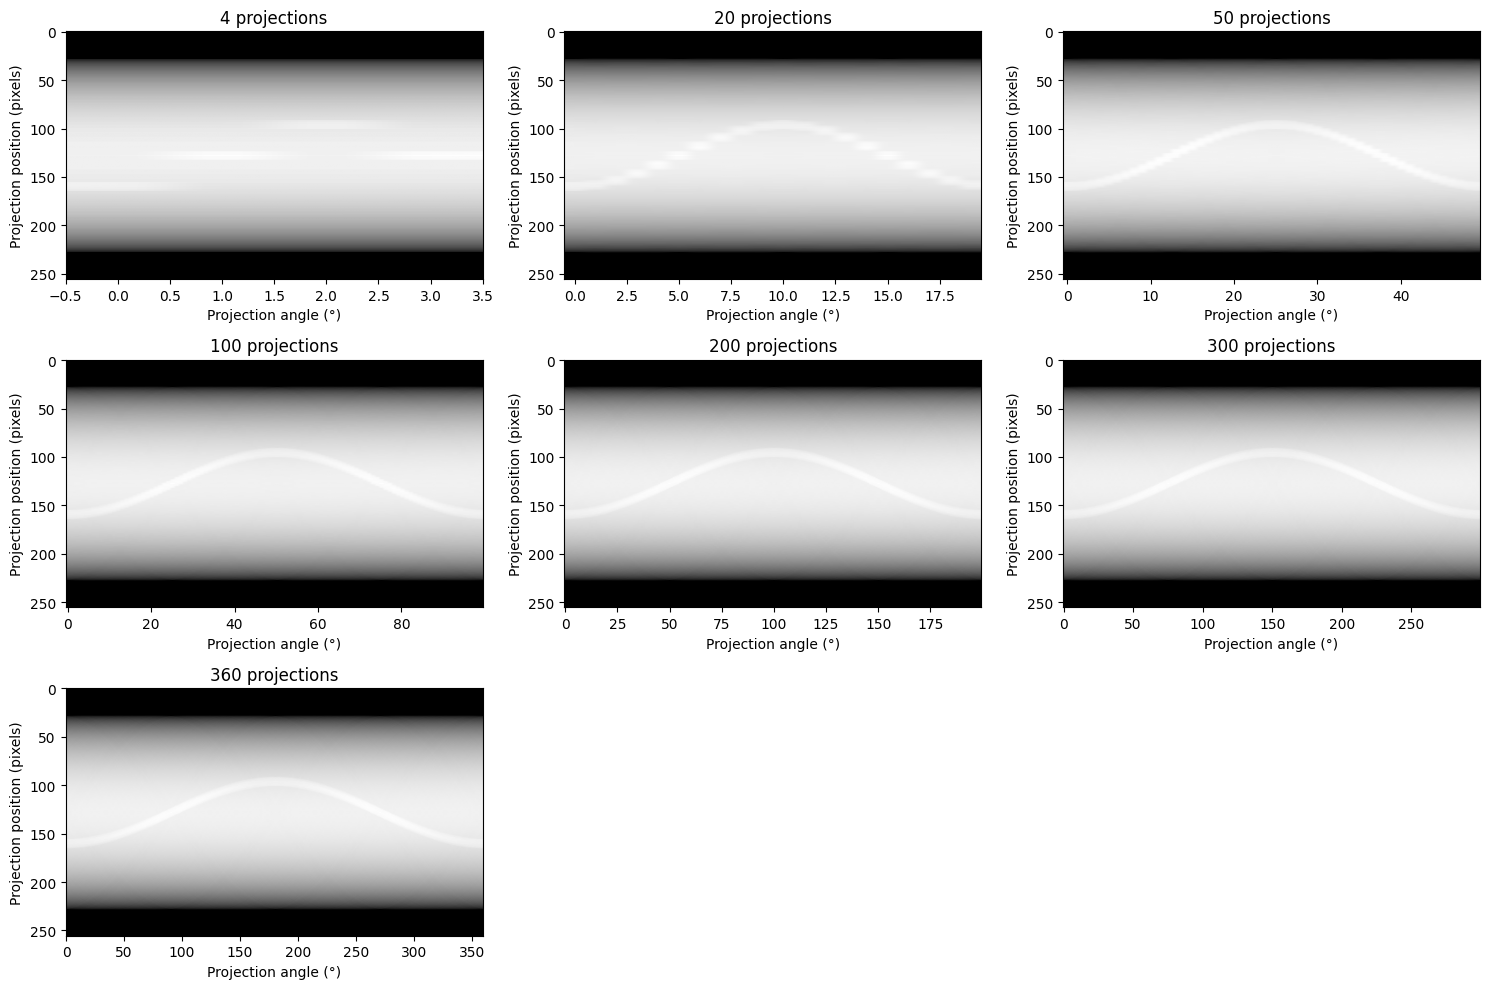

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

# Assuming `phantom` from section 2.2 already exists
# If not, you can re-run that code block first

# ---------- Define projection angles ----------
projection_sets = [4, 20, 50, 100, 200, 300, 360]

plt.figure(figsize=(15, 10))

for i, n_proj in enumerate(projection_sets, 1):
    # Create equally spaced angles between 0 and 360 degrees
    theta = np.linspace(0., 360., n_proj, endpoint=False)

    # Compute Radon transform (sinogram)
    sinogram = radon(phantom, theta=theta, circle=True)

    # Plot the sinogram
    plt.subplot(3, 3, i)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.title(f"{n_proj} projections")
    plt.xlabel("Projection angle (°)")
    plt.ylabel("Projection position (pixels)")

plt.tight_layout()
plt.show()


In [ ]:
How do the sinograms change with the number of projections?
→ The sinogram becomes smoother and more detailed as the number of projections increases.
Fewer projections produce discontinuous or undersampled patterns.

Q: What is the effect of increasing/decreasing the number of projections?
→

Increasing projections → higher image quality, smoother reconstruction, fewer artifacts.

Decreasing projections → faster acquisition, but poorer reconstruction with streak artifacts.

SyntaxError: invalid character '→' (U+2192) (581365060.py, line 2)

### 2.4 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Make use of the ``matplotlib`` to show the original and reconstructed images of the phantom and compare the pixel intensity signal across the lesion profile (similarly to section 2.1).In addition, provide evaluation metric you could consider useful for this purpose (image difference, mean square error (MSE), peak signal to noise ratio (PSNR), structural index similarity (SSIM), etc.). Then, discuss the results.

RAMP Filter -> MSE: 0.0014, PSNR: 34.60 dB, SSIM: 0.8759
SHEPP-LOGAN Filter -> MSE: 0.0014, PSNR: 34.57 dB, SSIM: 0.9115
COSINE Filter -> MSE: 0.0017, PSNR: 33.74 dB, SSIM: 0.9552
HAMMING Filter -> MSE: 0.0020, PSNR: 33.07 dB, SSIM: 0.9632
HANN Filter -> MSE: 0.0021, PSNR: 32.83 dB, SSIM: 0.9651


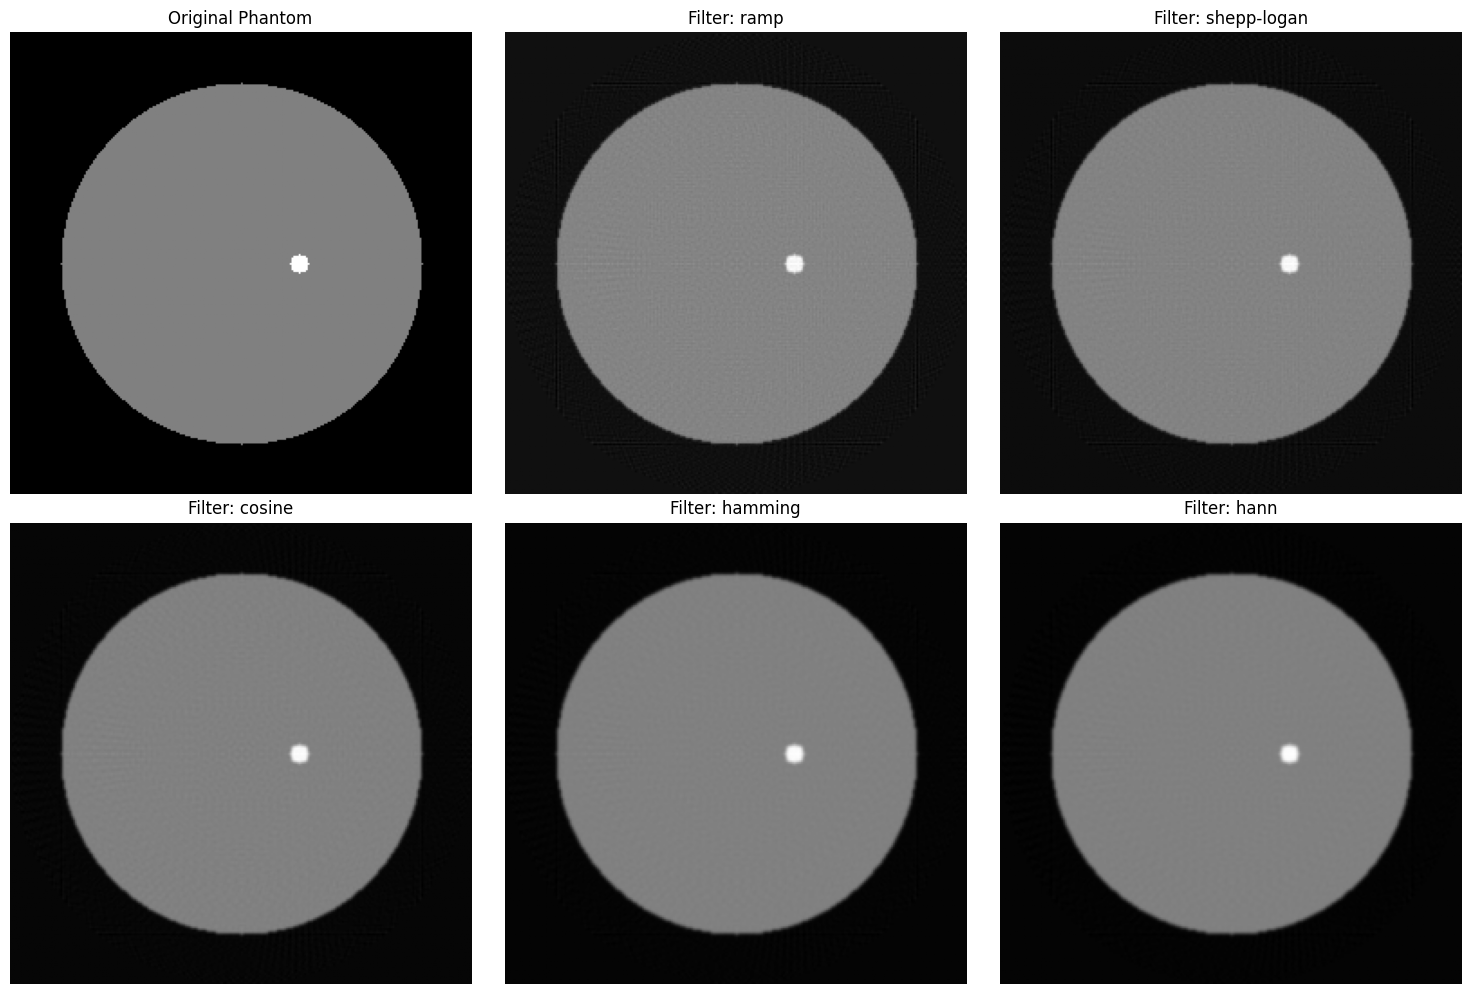

RAMP Filter -> MSE: 0.0014, PSNR: 34.60 dB, SSIM: 0.8759
SHEPP-LOGAN Filter -> MSE: 0.0014, PSNR: 34.57 dB, SSIM: 0.9115
COSINE Filter -> MSE: 0.0017, PSNR: 33.74 dB, SSIM: 0.9552
HAMMING Filter -> MSE: 0.0020, PSNR: 33.07 dB, SSIM: 0.9632
HANN Filter -> MSE: 0.0021, PSNR: 32.83 dB, SSIM: 0.9651


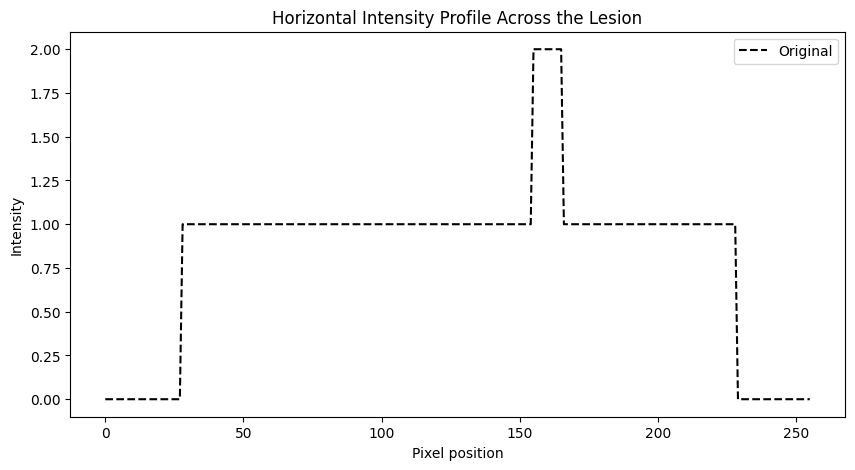

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# ----- Step 1: Generate the sinogram -----
theta = np.linspace(0., 360., 180, endpoint=False)  # 180 projections
sinogram = radon(phantom, theta=theta, circle=True)

# ----- Step 2: Reconstruct using different filters -----
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

reconstructions = {}
for f in filters:
    recon = iradon(sinogram, theta=theta, filter_name=f, circle=True)
    reconstructions[f] = recon

# ----- Step 3: Evaluation metrics -----
for f, img in reconstructions.items():
    mse = mean_squared_error(phantom, img)
    psnr = peak_signal_noise_ratio(phantom, img, data_range=phantom.max() - phantom.min())
    ssim = structural_similarity(phantom, img, data_range=phantom.max() - phantom.min())
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

# ----- Step 4: Plot comparison -----
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Original phantom
axes[0].imshow(phantom, cmap='gray')
axes[0].set_title("Original Phantom")

# Reconstructed images
for i, f in enumerate(filters, start=1):
    axes[i].imshow(reconstructions[f], cmap='gray')
    axes[i].set_title(f"Filter: {f}")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# ----- Step 5: Plot intensity profile -----
row = phantom.shape[0] // 2
plt.figure(figsize=(10,5))
plt.plot(phantom[row, :], 'k--', label='Original')

for f, img in reconstructions.items():
    mse = mean_squared_error(phantom, img)
    psnr = peak_signal_noise_ratio(phantom, img, data_range=phantom.max() - phantom.min())
    ssim = structural_similarity(phantom, img, data_range=phantom.max() - phantom.min())
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

plt.title("Horizontal Intensity Profile Across the Lesion")
plt.xlabel("Pixel position")
plt.ylabel("Intensity")
plt.legend()
plt.show()


### 2.5 Sheep logan phantom (2 points)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis for the **noisy sinogram** for one case (approach, filter,...) using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms?


<img src='images_4_notebook/SheepLoganPhantom.png' width="1000">



In order to create **noisy sinograms**, you can add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your noise-free sinograms (not to the image!) and reconstruct the phantom images with the different filters. Plot the reconstruction image and the (horizontal) intensity profile along specific row. Then, comment on the effects of the filters on the reconstructed phatom images.


RAMP Filter -> MSE: 0.0064, PSNR: 21.91 dB, SSIM: 0.3761
SHEPP-LOGAN Filter -> MSE: 0.0047, PSNR: 23.29 dB, SSIM: 0.4151
COSINE Filter -> MSE: 0.0030, PSNR: 25.20 dB, SSIM: 0.5256
HAMMING Filter -> MSE: 0.0028, PSNR: 25.46 dB, SSIM: 0.5975
HANN Filter -> MSE: 0.0028, PSNR: 25.47 dB, SSIM: 0.6221


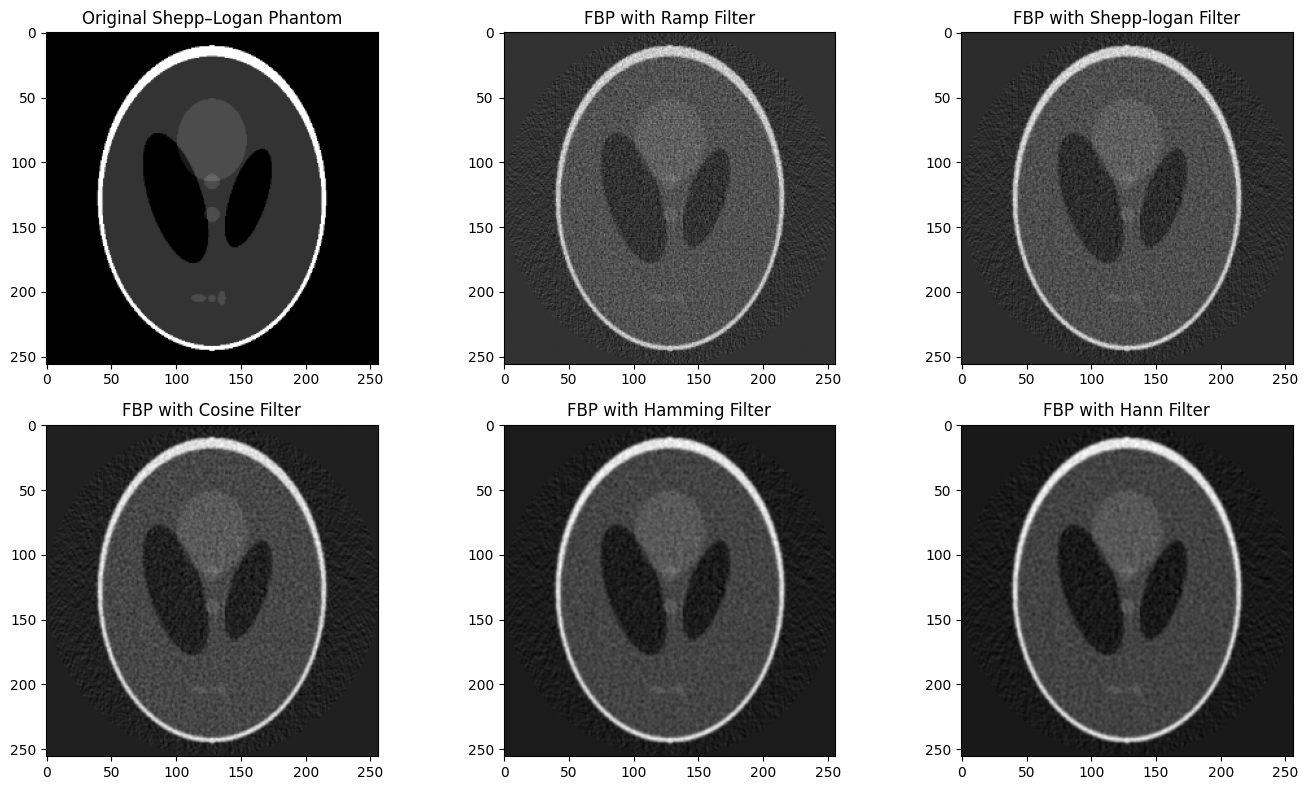

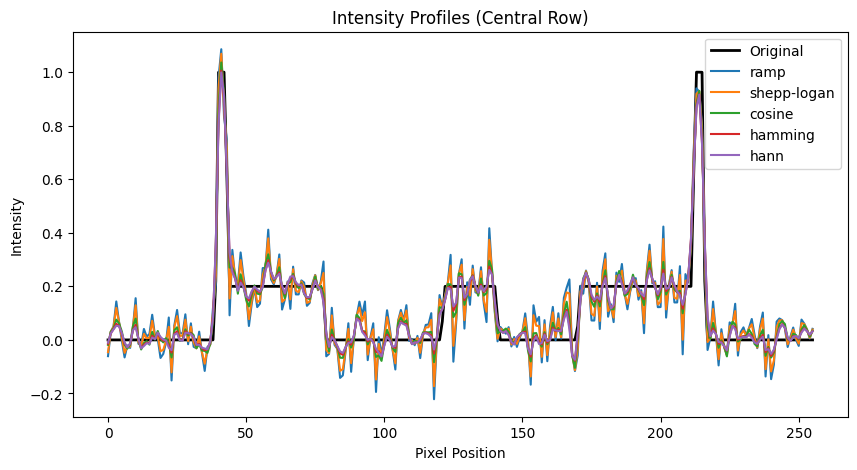

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
# ----- Step 1: Create the Shepp–Logan phantom -----
logan_phantom = shepp_logan_phantom()
logan_phantom = resize(logan_phantom, (256, 256))  # Resize for consistency

# ----- Step 2: Generate sinogram -----
theta = np.linspace(0., 360., 200, endpoint=False)
sinogram = radon(logan_phantom, theta=theta)

# ----- Step 3: Add Poisson noise -----
lam = 10
noisy_sinogram = np.random.poisson(sinogram * lam) / lam

# ----- Step 4: Reconstruct using different filters -----
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
reconstructions = {}

for f in filters:
    img = iradon(noisy_sinogram, theta=theta, filter_name=f)
    reconstructions[f] = img

# ----- Step 5: Evaluate and compare -----
for f, img in reconstructions.items():
    mse = mean_squared_error(logan_phantom, img)
    psnr = peak_signal_noise_ratio(
        logan_phantom, img,
        data_range=logan_phantom.max() - logan_phantom.min()
    )
    ssim = structural_similarity(
        logan_phantom, img,
        data_range=logan_phantom.max() - logan_phantom.min()
    )
    print(f"{f.upper()} Filter -> MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

# ----- Step 6: Plot results -----
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
axes[0].imshow(logan_phantom, cmap='gray')
axes[0].set_title("Original Shepp–Logan Phantom")

for i, f in enumerate(filters, 1):
    axes[i].imshow(reconstructions[f], cmap='gray')
    axes[i].set_title(f"FBP with {f.capitalize()} Filter")

plt.tight_layout()
plt.show()

# ----- Step 7: Intensity profile comparison -----
row = logan_phantom.shape[0] // 2
plt.figure(figsize=(10, 5))
plt.plot(logan_phantom[row, :], label='Original', color='black', linewidth=2)
for f in filters:
    plt.plot(reconstructions[f][row, :], label=f)
plt.title("Intensity Profiles (Central Row)")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.legend()
plt.show()

